In [1]:
from os import system, path
from math import log2
import subprocess
import re


# Output Parsing
from dataclasses import dataclass


@dataclass
class SimResult:
    hit: int
    miss: int


output_regex = re.compile(r"HIT:\s*(\d+)\s*MISS:\s*(\d+)\s*")


def parse_output(sim_output: str):
    hit, miss = map(int, output_regex.match(
        sim_output.splitlines()[-1]).groups())
    return SimResult(hit, miss)


# Header Generation
with open("CacheSimSize.h.template") as f:
    template_size = f.read()
with open("CacheSimAsso.h.template") as f:
    template_asso = f.read()


def size_header(cache_size: int, block_size: int):
    assert log2(cache_size).is_integer()
    assert log2(block_size).is_integer()

    return template_size.format(cache_size, int(log2(cache_size)), block_size, int(log2(block_size)))


def gen_size_header(cache_size: int, block_size: int, output_path="CacheSimSize.h"):
    with open(output_path, "w") as f:
        f.write(size_header(cache_size, block_size))


def asso_header(cache_size: int, way: int):
    assert log2(cache_size).is_integer()

    return template_asso.format(cache_size, int(log2(cache_size)), way)


def gen_asso_header(cache_size: int, way: int, output_path="CacheSimAsso.h"):
    with open(output_path, "w") as f:
        f.write(asso_header(cache_size, way))

# Compile & Run


def compile_size(cache_size: int, block_size: int):
    gen_size_header(cache_size, block_size)
    system("gcc CacheSimSize.c -w -o CacheSimSize.out")


def run_size(tracefile: str):
    return subprocess.check_output(
        ["./CacheSimSize.out", tracefile]).decode('utf-8')


def compile_lru(cache_size: int, way: int):
    gen_asso_header(cache_size, way)
    system("gcc CacheSimLRU.c -w -o CacheSimLRU.out")


def run_lru(tracefile: str):
    return subprocess.check_output(
        ["./CacheSimLRU.out", tracefile]).decode('utf-8')

def compile_rr(cache_size: int, way: int):
    gen_asso_header(cache_size, way)
    system("gcc CacheSimRR.c -w -o CacheSimRR.out")


def run_rr(tracefile: str):
    return subprocess.check_output(
        ["./CacheSimRR.out", tracefile]).decode('utf-8')



In [2]:
# Main
tracefile = "gcc_ld_trace.txt"

if not path.isfile(tracefile):
    print(f"Item at `{tracefile}` does not exist or is not a file")
    exit(1)

## Q1

### Simulate

In [3]:
import pandas as pd
from IPython.display import display, Markdown

block_sizes = [4, 8, 16, 32]
cache_sizes = [4, 8, 16, 32]
table = ""
data = list()

table += "|Block size (Bytes)|" + "".join(f"Cache Size={cache_size}KB|" for cache_size in cache_sizes)
table += "\n|---|" + "---|" * len(cache_sizes) + "\n"

for j, block_size in enumerate(block_sizes):
    table += f"|{block_size}|"
    for i, cache_size in enumerate(cache_sizes):
        compile_size(cache_size, block_size)
        result = parse_output(run_size(tracefile))
        miss_rate = result.miss / (result.miss + result.hit)

        data.append([block_size, cache_size, result.hit, result.miss, miss_rate])

        table += f"HIT: {result.hit} MISS: {result.miss}|"
    table += "\n"


display(Markdown(table))

data = pd.DataFrame(data, columns=["block_size", "cache_size", "hit", "miss", "miss_rate"])

|Block size (Bytes)|Cache Size=4KB|Cache Size=8KB|Cache Size=16KB|Cache Size=32KB|
|---|---|---|---|---|
|4|HIT: 1669560 MISS: 330441|HIT: 1775198 MISS: 224803|HIT: 1849934 MISS: 150067|HIT: 1895088 MISS: 104913|
|8|HIT: 1652147 MISS: 347854|HIT: 1766215 MISS: 233786|HIT: 1846558 MISS: 153443|HIT: 1895885 MISS: 104116|
|16|HIT: 1677463 MISS: 322538|HIT: 1784151 MISS: 215850|HIT: 1860161 MISS: 139840|HIT: 1906747 MISS: 93254|
|32|HIT: 1687566 MISS: 312435|HIT: 1793431 MISS: 206570|HIT: 1867498 MISS: 132503|HIT: 1911848 MISS: 88153|


In [4]:
data

,block_size,cache_size,hit,miss,miss_rate
0,4,4,1669560,330441,0.165220
1,4,8,1775198,224803,0.112401
2,4,16,1849934,150067,0.075033
3,4,32,1895088,104913,0.052456
4,8,4,1652147,347854,0.173927
5,8,8,1766215,233786,0.116893
6,8,16,1846558,153443,0.076721
7,8,32,1895885,104116,0.052058
8,16,4,1677463,322538,0.161269
9,16,8,1784151,215850,0.107925


### Plot

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

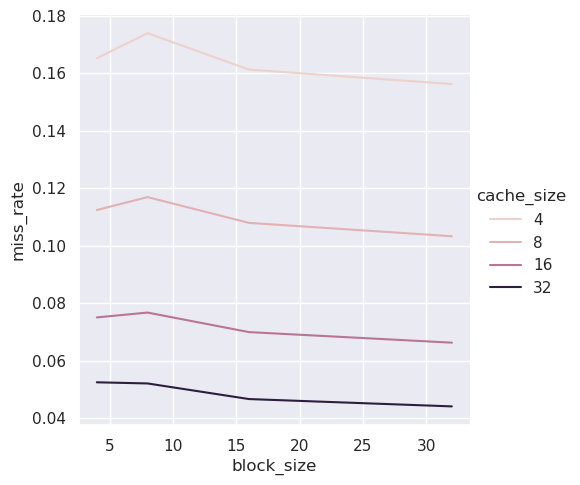

In [6]:
sns.relplot(data=data, kind="line", x="block_size", y="miss_rate", hue="cache_size")
plt.show()

# Q2

### Simulate

In [7]:
cache_sizes = [1, 4, 8, 32, 512, 1024]
table = ""
data = list()

table += "|Cache size (KB)|Two-way LRU|Two-way RR|Four-way LRU|Four-way RR|\n"
table += "|" + "---|"*5 + "\n"



for cache_size in cache_sizes:
    table += f"|{cache_size}|"

    compile_lru(cache_size, 2)
    result = parse_output(run_lru(tracefile))
    miss_rate = result.miss / (result.miss + result.hit)
    data.append(["lru", cache_size, 2, result.hit, result.miss, miss_rate])
    table += f"HIT: {result.hit} MISS: {result.miss}|"

    compile_rr(cache_size, 2)
    result = parse_output(run_rr(tracefile))
    miss_rate = result.miss / (result.miss + result.hit)
    data.append(["rr", cache_size, 2, result.hit, result.miss, miss_rate])
    table += f"HIT: {result.hit} MISS: {result.miss}|"

    compile_lru(cache_size, 4)
    result = parse_output(run_lru(tracefile))
    miss_rate = result.miss / (result.miss + result.hit)
    data.append(["lru", cache_size, 4, result.hit, result.miss, miss_rate])
    table += f"HIT: {result.hit} MISS: {result.miss}|"

    compile_rr(cache_size, 4)
    result = parse_output(run_rr(tracefile))
    miss_rate = result.miss / (result.miss + result.hit)
    data.append(["rr", cache_size, 4, result.hit, result.miss, miss_rate])
    table += f"HIT: {result.hit} MISS: {result.miss}|"

    table += "\n"

display(Markdown(table))

data = pd.DataFrame(data, columns=["method", "cache_size", "way", "hit", "miss", "miss_rate"])

|Cache size (KB)|Two-way LRU|Two-way RR|Four-way LRU|Four-way RR|
|---|---|---|---|---|
|1|HIT: 1650098 MISS: 349903|HIT: 1623165 MISS: 376836|HIT: 1783015 MISS: 216986|HIT: 1759111 MISS: 240890|
|4|HIT: 1834446 MISS: 165555|HIT: 1821673 MISS: 178328|HIT: 1909094 MISS: 90907|HIT: 1899892 MISS: 100109|
|8|HIT: 1897961 MISS: 102040|HIT: 1890029 MISS: 109972|HIT: 1948795 MISS: 51206|HIT: 1943335 MISS: 56666|
|32|HIT: 1959204 MISS: 40797|HIT: 1956301 MISS: 43700|HIT: 1971769 MISS: 28232|HIT: 1970408 MISS: 29593|
|512|HIT: 1974717 MISS: 25284|HIT: 1974691 MISS: 25310|HIT: 1974753 MISS: 25248|HIT: 1974753 MISS: 25248|
|1024|HIT: 1974753 MISS: 25248|HIT: 1974753 MISS: 25248|HIT: 1974753 MISS: 25248|HIT: 1974753 MISS: 25248|


In [8]:
data

,method,cache_size,way,hit,miss,miss_rate
0,lru,1,2,1650098,349903,0.174951
1,rr,1,2,1623165,376836,0.188418
2,lru,1,4,1783015,216986,0.108493
3,rr,1,4,1759111,240890,0.120445
4,lru,4,2,1834446,165555,0.082777
5,rr,4,2,1821673,178328,0.089164
6,lru,4,4,1909094,90907,0.045453
7,rr,4,4,1899892,100109,0.050054
8,lru,8,2,1897961,102040,0.051020
9,rr,8,2,1890029,109972,0.054986


### Plot

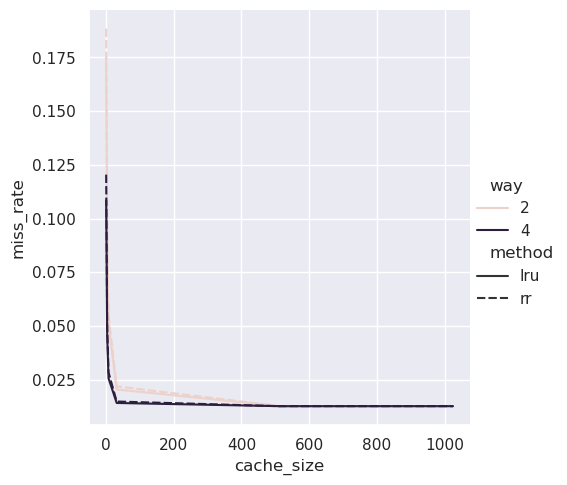

In [9]:
sns.relplot(data=data, kind="line", x="cache_size", y ="miss_rate", hue="way", style="method")
plt.show()